# Approach using VAR

In [18]:
import os
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import datetime as dt

import seaborn as sns

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

# Load Data and Set Index

In [19]:
# Paths
cwd = os.getcwd()
path_to_challenge1 = os.path.dirname(os.path.dirname(cwd))
path_to_all_data = os.path.join(path_to_challenge1, 'data', 'dataset_500.csv')
path_to_test_data = os.path.join(path_to_challenge1, 'data', 'test_dataset_500.csv')
path_to_train_data = os.path.join(path_to_challenge1, 'data', 'training_dataset_500.csv')

In [20]:
# All Data
df = pd.read_csv(path_to_all_data)
df_test = pd.read_csv(path_to_test_data)
df_train = pd.read_csv(path_to_train_data)

In [21]:
df.head()

,ID,Label,House,Year,Month,Temperature,Daylight,EnergyProduction
0,0,0,1,2011,7,26.2,178.9,740
1,1,1,1,2011,8,25.8,169.7,731
2,2,2,1,2011,9,22.8,170.2,694
3,3,3,1,2011,10,16.4,169.1,688
4,4,4,1,2011,11,11.4,169.1,650


In [22]:
# Keeping only main features (avoiding highly correlated or useless columns)
key_cols = ['House', 'Temperature', 'Daylight', 'EnergyProduction']
ts_cols = ['Temperature', 'Daylight', 'EnergyProduction']

# Set Index Method
def get_datetime_index(input_df, key_cols):
    input_df['DateTime'] = pd.to_datetime(input_df.Year.map(str) + input_df.Month.map(str), format="%Y%m")
    input_df.set_index(['DateTime'], inplace=True)
    return input_df[key_cols]

# Get Index
df = get_datetime_index(df, key_cols)
df_test = get_datetime_index(df_test, key_cols)
df_train = get_datetime_index(df_train, key_cols)

In [23]:
df.head()

,House,Temperature,Daylight,EnergyProduction
DateTime,,,,
2011-07-01,1,26.2,178.9,740
2011-08-01,1,25.8,169.7,731
2011-09-01,1,22.8,170.2,694
2011-10-01,1,16.4,169.1,688
2011-11-01,1,11.4,169.1,650


# Model TimeSeries

It is important to notice that the dataset include multiple samplingpoints (Houses). In the present work, each house will treated indepedently and model fit/parameters will be independently obtained for each. 

In [24]:
def get_VAR_prediction(df_train, df_test, house, ts_cols, maxlagsint, ic, trend):
    
    #creating the train and validation set
    train = df_train[ df_train['House'] == house ][ts_cols].asfreq('MS')
    
    # Checking Stationarity
    # Similar to the Augmented Dickey-Fuller test for univariate series, we have Johansen’s test for checking the 
    # stationarity of any multivariate time series data. For a series to be stationary, the eigenvalues of should 
    # be less than 1 in modulus. 
    eigen = coint_johansen(train,-1,1).eig
    if all(i < 1.0 for i in eigen): 
        pass
        #print('All eigen values are ok')
    else: 
        print('Problem with Eigen Value', eigen)

    # Fit the model
    # Parameters
    # - maxlagsint: Maximum number of lags to check for order selection, defaults to 12 * (nobs/100.)**(1./4), 
    #   see select_order function 
    # - method{‘ols’}: Estimation method to use
    # - ic{‘aic’, ‘fpe’, ‘hqic’, ‘bic’, None}: Information criterion to use for VAR order selection. 
    # aic : Akaike fpe : Final prediction error hqic : Hannan-Quinn bic : Bayesian a.k.a. Schwarzverbosebool, 
    # - trend: str {“c”, “ct”, “ctt”, “nc”}: “c” - add constant “ct” - constant and trend “ctt” - constant, 
    # linear and quadratic trend “nc” - co constant, no trend Note that these are prepended to the columns 
    # of the dataset.
    model = VAR(endog=train)
    if maxlagsint:
        model_fit = model.fit(maxlags=maxlagsint, ic=ic, trend=trend)
    else:
        model_fit = model.fit(ic=ic, trend=trend)
        
    # make prediction on validation
    prediction = model_fit.forecast(model_fit.y, steps=1)
    
    # Focus on Extracting "EnergyProduction"
    energy_pred = prediction.tolist()[0][-1]
    energy_value = df_test['EnergyProduction'].tolist()[0]
    error = abs(energy_value - energy_pred)/energy_value
    
    return energy_pred #, energy_value, error

In [25]:
houses = df['House'].unique()
prediction_list = []

for house in houses: 
    # As the dataset is small, parameter optimisation will be performed with a grid search, each House having its
    # own optimal prediction
    actual_value = df_test.loc[df_test['House'] == house, 'EnergyProduction'].iloc[0]
    predicted = []
    for trend in ['c', 'nc', 'ct', 'ctt']:
        for ic in ['aic', 'fpe', 'hqic', 'bic', None]:
            for maxlagsint in [1, 2, 3, 4]:
                value_predicted = get_VAR_prediction(df_train, df_test, house, ts_cols, maxlagsint, ic, trend)
                predicted.append(
                    {'trend': trend,
                     'ic': ic,
                     'maxlags': maxlagsint,
                     'prediction': value_predicted,
                     'error': abs(actual_value - value_predicted)
                    })
    # Select Best
    bestPrediction = min(predicted, key=lambda x:x['error'])
    d = {
        'House' : house,
        'ModelParamters_trend' : bestPrediction['trend'],
        'ModelParamters_ic' : bestPrediction['ic'],
        'ModelParamters_maxlags' : bestPrediction['maxlags'],
        'Error': bestPrediction['error'],
        'Prediction' : bestPrediction['prediction']
    }
    prediction_list.append(d)

df_prediction = pd.DataFrame(prediction_list)

In [26]:
# Results
df_prediction.head()

,Error,House,ModelParamters_ic,ModelParamters_maxlags,ModelParamters_trend,Prediction
0,19.019555,1,aic,3,ct,797.019555
1,19.753771,2,aic,4,ctt,646.753771
2,29.339770,3,aic,4,ct,764.339770
3,65.865639,4,None,3,c,598.865639
4,65.865639,5,None,3,c,598.865639


In [27]:
# Print File with Predicted Values
df_prediction_print = df_prediction[['House', 'Prediction']]
df_prediction_print.to_csv('predicted_energy_production.csv', index=False)

In [28]:
# Combine DF
df_all = df_test.merge(df_prediction, left_on='House', right_on='House')
df_all.head()

,House,Temperature,Daylight,EnergyProduction,Error,ModelParamters_ic,ModelParamters_maxlags,ModelParamters_trend,Prediction
0,1,22.0,125.5,778,19.019555,aic,3,ct,797.019555
1,2,21.1,123.1,627,19.753771,aic,4,ctt,646.753771
2,3,21.9,126.8,735,29.339770,aic,4,ct,764.339770
3,4,20.2,125.2,533,65.865639,None,3,c,598.865639
4,5,20.2,125.2,533,65.865639,None,3,c,598.865639


In [31]:
# Error
MAPE = np.mean(np.abs((df_all['EnergyProduction'] - df_all['Prediction']) / df_all['EnergyProduction'])) * 100
MAPE

4.023386014469117

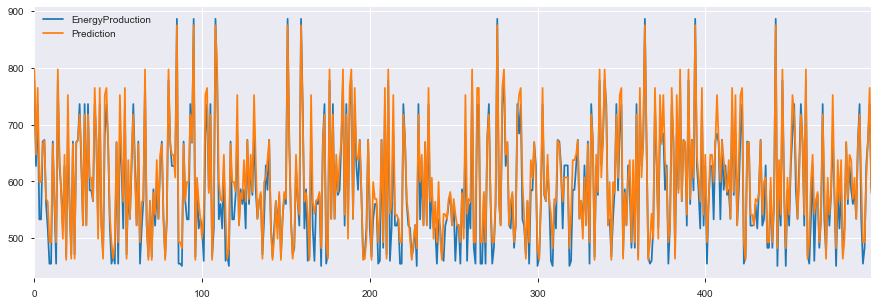

In [30]:
# Prediction
df_all[['EnergyProduction', 'Prediction']].plot(figsize=(15,5))

### Clearly the main problem of the present appoach regarding parameter optimisisation is related to Overfitting. This could be addressed by grouping houses by type (which seems possible as based on the Data Exploration) and then identify the best hyperparameters for such "House Type".